# Modelling of physical systems

## Fifth Assignment

### Miłosz Góralczyk

### Extend the Monte-Carlo advection solver to two spatial dimensions

This notebook contains mostly modified code from the laboratories, adjusted for a second dimension movement.

#### Objective

The goal of this model is to simulate the advection of a passive particle distribution on two dimensional grid using a Monte Carlo approach, 

After that, a validation of the numerical result against an exact analytic solution is plotted as a comparison

**Algorithm Steps**

- Defined a 2D spatial grid and seeded it with particles from Gaussian Distribution
- Introduced a constant flow field in both the x and y directions
- Applied time-discrete advection via a probabilistic shifting of particles on the grid.
- Computed the analytic solution, realized as from earlier laboratories - a shift of the substance's density based on the advection's parameters
- Plotted both Monte Carlo and Analytic results

**Chosen Parameters**

Flow Field: 
$u_x = 1.2$, $u_y = 0.7$

Initial Distribution:
$x - N(250, 80^2)$, $y - N(250, 70^2)$

The discrete Time-Space parameters were imported from the laboratories Notebook

In [37]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot

In [38]:
# Defining a 2D Flow Field "constant"

FLOW_UX = 1.2  # x-direction velocity
FLOW_UY = 0.7  # y-direction velocity

In [39]:
PARAMS_XY = SimpleNamespace(
    span_x=1000,
    span_y=1000,
    n_cell_x=50,
    n_cell_y=50,
)
PARAMS_XY.step_x = PARAMS_XY.span_x / PARAMS_XY.n_cell_x
PARAMS_XY.step_y = PARAMS_XY.span_y / PARAMS_XY.n_cell_y

PARAMS_P2D = SimpleNamespace(
    n_part=2000,
    norm=1e10,
    dist_x=scipy.stats.norm(loc=250, scale=80),
    dist_y=scipy.stats.norm(loc=240, scale=70),
)

RNG = np.random.default_rng(seed=2137)


In [40]:
PARAMS_T2D = SimpleNamespace(
    span=300,
    n_step=30,
    wind_x=FLOW_UX,
    wind_y=FLOW_UY
)
PARAMS_T2D.step = PARAMS_T2D.span / PARAMS_T2D.n_step
PARAMS_T2D.courant_x = PARAMS_T2D.wind_x / PARAMS_XY.step_x * PARAMS_T2D.step
PARAMS_T2D.courant_y = PARAMS_T2D.wind_y / PARAMS_XY.step_y * PARAMS_T2D.step


In [41]:
def sample_2d(*, params_p, params_xy, rng):
    """Samples 2D particle positions from independent Gaussians"""
    u01_x = rng.uniform(0, 1, params_p.n_part)
    u01_y = rng.uniform(0, 1, params_p.n_part)

    pos_x = params_p.dist_x.ppf(u01_x)
    pos_y = params_p.dist_y.ppf(u01_y)

    mult = np.ones_like(pos_x) / params_p.n_part * params_p.norm

    return {
        'cell_x': (pos_x / params_xy.step_x).astype(int),
        'cell_y': (pos_y / params_xy.step_y).astype(int),
        'mult': mult.astype(int),
    }


In [42]:
def advect_2d(*, particles, params_p, params_t, rng):
    """Advect particles in 2D using Monte Carlo approach"""
    prob_x = abs(params_t.courant_x)
    prob_y = abs(params_t.courant_y)
    assert prob_x < 1 and prob_y < 1

    for _ in range(params_t.n_step):
        shift_x = rng.uniform(0, 1, params_p.n_part) < prob_x
        shift_y = rng.uniform(0, 1, params_p.n_part) < prob_y
        particles['cell_x'] += shift_x
        particles['cell_y'] += shift_y


In [43]:
def plot_2d_particles(particles, params_xy):
    """Plot 2D particle positions and density heatmap"""
    fig, axs = pyplot.subplots(1, 2, figsize=(12, 6), tight_layout=True)

    # Scatter plot
    axs[0].scatter(
        particles['cell_x'], particles['cell_y'],
        s=1 + 2 * particles['mult'] / particles['mult'].mean(),
        alpha=0.5
    )
    axs[0].set_title('Particle Scatter')
    axs[0].set_xlim(0, params_xy.n_cell_x)
    axs[0].set_ylim(0, params_xy.n_cell_y)
    axs[0].set_aspect('equal')
    axs[0].grid()

    # 2D histogram
    h2d, _, _ = np.histogram2d(
        particles['cell_x'],
        particles['cell_y'],
        bins=[params_xy.n_cell_x, params_xy.n_cell_y],
        weights=particles['mult'],
        range=[[0, params_xy.n_cell_x], [0, params_xy.n_cell_y]],
    )
    im = axs[1].imshow(
        h2d.T,
        origin='lower',
        extent=(0, params_xy.n_cell_x, 0, params_xy.n_cell_y),
        aspect='equal',
        cmap='viridis'
    )
    axs[1].set_title('Particle Density Heatmap')
    fig.colorbar(im, ax=axs[1])
    show_plot()


In [ ]:
def analytic_density_2d(params_p, params_t, params_xy):
    """Returns the expected Gaussian density heatmap after advection"""
    # Compute displacement
    dx = FLOW_UX * params_t.span
    dy = FLOW_UY * params_t.span

    # Shifted distributions
    final_x = scipy.stats.norm(loc=params_p.dist_x.mean() + dx, scale=params_p.dist_x.std())
    final_y = scipy.stats.norm(loc=params_p.dist_y.mean() + dy, scale=params_p.dist_y.std())

    # 2D grid for cell centers
    x = (np.arange(params_xy.n_cell_x) + 0.5) * params_xy.step_x
    y = (np.arange(params_xy.n_cell_y) + 0.5) * params_xy.step_y
    xx, yy = np.meshgrid(x, y, indexing='ij')

    # Compute density values
    density = final_x.pdf(xx) * final_y.pdf(yy)
    density *= params_p.norm  # scale to match particle total

    return density


In [45]:
def plot_comparison(particles, analytic_density, params_xy):
    """Side-by-side of simulated and analytic results"""
    _, axs = pyplot.subplots(1, 2, figsize=(12, 5), tight_layout=True)

    # Monte Carlo result
    h2d, _, _ = np.histogram2d(
        particles['cell_x'],
        particles['cell_y'],
        bins=[params_xy.n_cell_x, params_xy.n_cell_y],
        weights=particles['mult'],
        range=[[0, params_xy.n_cell_x], [0, params_xy.n_cell_y]],
    )
    axs[0].imshow(
        h2d.T, origin='lower', cmap='viridis',
        extent=(0, params_xy.n_cell_x, 0, params_xy.n_cell_y),
        aspect='equal'
    )
    axs[0].set_title('Monte Carlo Advection')

    # Analytic density
    axs[1].imshow(
        analytic_density.T, origin='lower', cmap='viridis',
        extent=(0, params_xy.n_cell_x, 0, params_xy.n_cell_y),
        aspect='equal'
    )
    axs[1].set_title('Analytic Solution')

    show_plot()


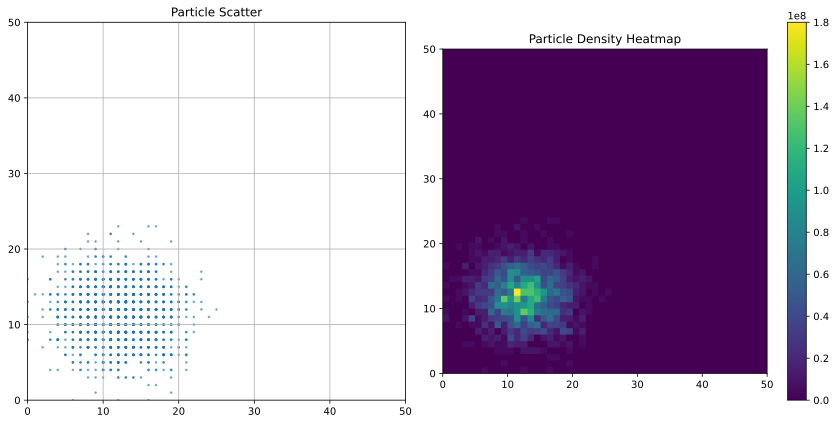

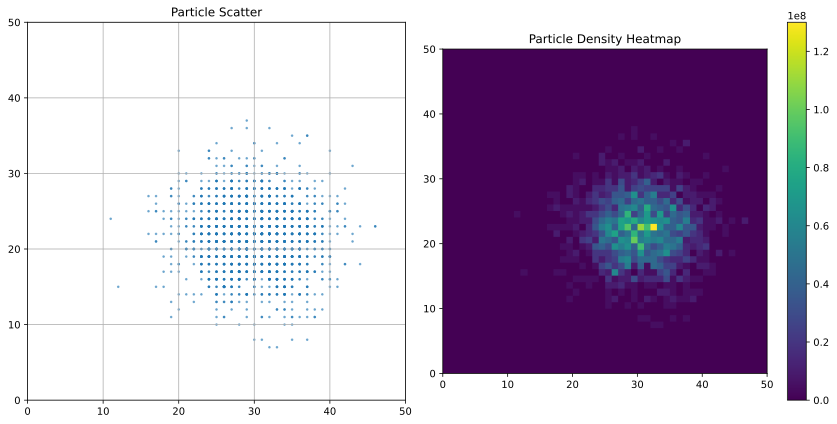

In [46]:
PARTICLES_2D = sample_2d(params_p=PARAMS_P2D, params_xy=PARAMS_XY, rng=RNG)
plot_2d_particles(PARTICLES_2D, params_xy=PARAMS_XY)

advect_2d(
    particles=PARTICLES_2D,
    params_p=PARAMS_P2D,
    params_t=PARAMS_T2D,
    rng=RNG
)

plot_2d_particles(PARTICLES_2D, params_xy=PARAMS_XY)


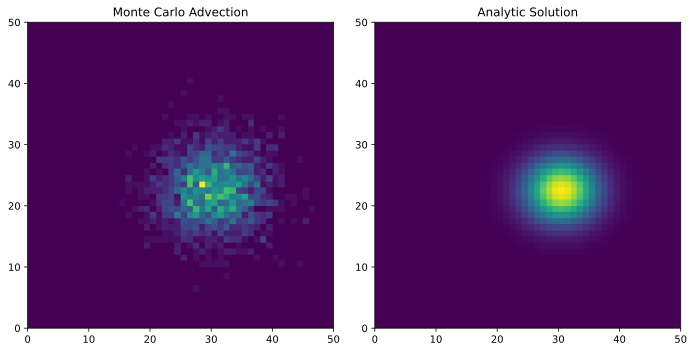

In [47]:
PARTICLES_2D = sample_2d(params_p=PARAMS_P2D, params_xy=PARAMS_XY, rng=RNG)

advect_2d(
    particles=PARTICLES_2D,
    params_p=PARAMS_P2D,
    params_t=PARAMS_T2D,
    rng=RNG
)

ANALYTIC = analytic_density_2d(
    params_p=PARAMS_P2D,
    params_t=PARAMS_T2D,
    params_xy=PARAMS_XY
)

plot_comparison(PARTICLES_2D, ANALYTIC, PARAMS_XY)


### Observations and Conclusions

- As seen, the presented at the laboratories solution can with some ease be extended to two dimentional domain, where it mirrors the charasteristics of mostly-adequate uncertainty.
- the Monte Carlo simulation closely resembles the analytic solution in terms of mass shifting capabilities
- Monte Carlo simulation introduces though an unobservable in analytical solution diffusion and numerical noise, as a result of unpredictable particle behavior
- While not exactly identical, a better approximation could be achieved by upscaling the number of samples and shortening the discrete time-space steps, using more compute power to shorten the difference